# Installations

In [ ]:
!pip install keras-tuner --upgrade
# !rm -rf untitled_project

# Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import regularizers
from keras import backend as K
import keras_tuner
from keras_tuner import RandomSearch

import os
import cv2
import glob
from sklearn.utils import shuffle

tfds.disable_progress_bar()

import warnings
warnings.filterwarnings("ignore")

IMG_SIZE = 70

# Load Dataset
- Downloaded from Kaggle
  - https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
- Imported from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/malaria_nn_ds/data/cell_images_malaria.zip
#!unzip gdrive/MyDrive/malaria_nn_ds/data/Parasitized.zip
#!unzip gdrive/MyDrive/malaria_nn_ds/data/Uninfected.zip

In [ ]:
img_dir="cell_images_malaria"  
img_size=70

def load_img_data(path):
    image_files = glob.glob(os.path.join(path, "Parasitized/*.png")) + \
                  glob.glob(os.path.join(path, "Uninfected/*.png"))
    X, y = [], []
    for image_file in image_files:
        # 0 for uninfected and 1 for infected
        label = 0 if "Uninfected" in image_file else 1
        # load the image in gray scale
        img_arr = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        # resize the image to (70x70)
        img_resized = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_resized)
        y.append(label)
    return X, y

## Function of Plotting Loss and Accuracy

In [ ]:
# Plot Loss and Accuracy across Epoch values
def PlotLossAndAccuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=100)
    colors = ['#173F5F', '#F6D55C']
    font = {'fontweight':'bold'}
    plt.suptitle(title, fontsize=22, **font, y=1.05)
    # Accuracy
    ax1.plot(history.history['accuracy'], color=colors[0])
    ax1.plot(history.history['val_accuracy'], color=colors[1])
    ax1.set_title('Model Accuracy', fontsize=18, **font)
    ax1.set_ylabel('Accuracy', fontsize=14, **font)
    ax1.legend(['Train', 'Validation'], loc='upper left')
    # Loss
    ax2.plot(history.history['loss'], color=colors[0])
    ax2.plot(history.history['val_loss'], color=colors[1])
    ax2.set_title('Model Loss', fontsize=18, **font)
    ax2.set_ylabel('Loss', fontsize=14, **font)
    ax2.legend(['Train', 'Validation'], loc='upper right')
    for ax in [ax1, ax2]:
        ax.set_xlabel('Epoch', fontsize=14, **font)
        ax.tick_params(axis='both', which='major', labelsize=12)
    # Print Val Accuracy, Val Loss
    temp = history.history['val_accuracy']
    print('Validation Accuracy: %.4f' % max(temp))
    print('Validation Loss: %.4f' % history.history['val_loss'][temp.index(max(temp))])
    plt.tight_layout()
    plt.show()

# Data Preparation
- Reshape to 70 x 70
- Greyscale instead of RGB
- Using validation_split (20%) for Train and Validation Sets
  - X is entire dataset of X
      - 13,779 Parasitized
      - 13,779 Uninfected

  - y is entire dataset of y


In [ ]:
# Load Data
X, y = load_img_data(img_dir)

# Reshape and grayscale (1 Color Class instead of 3 RGB)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

# Standardize from RGB 255 to between 0 and 1
X = X / 255 

# Randomly shuffle dataset
# Validation_split doesn't shuffle data, so must shuffle entire dataset first
X, y = shuffle(X, y)

# Store input shape in variable
INPUT_SHAPE = (70,70,1)

In [ ]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (27558, 70, 70, 1)
y shape: (27558,)


## Visualize Malaria Cell Images
- 2 Parasitized
- 2 Uninfected

In [ ]:
def pictures(path):
    image_files = glob.glob(os.path.join(path, "Parasitized/*.png")) + \
                  glob.glob(os.path.join(path, "Uninfected/*.png"))
    images, labels = [], []
    for image_file in image_files:
        # 0 for uninfected and 1 for infected
        label = 0 if "Uninfected" in image_file else 1
        # load images
        img_arr = cv2.imread(image_file)
        # resize the image to (70x70)
        img_resized = cv2.resize(img_arr, (img_size, img_size))
        images.append(img_resized)
        labels.append(label)
    return images, labels

In [ ]:
images, labels = pictures(img_dir)

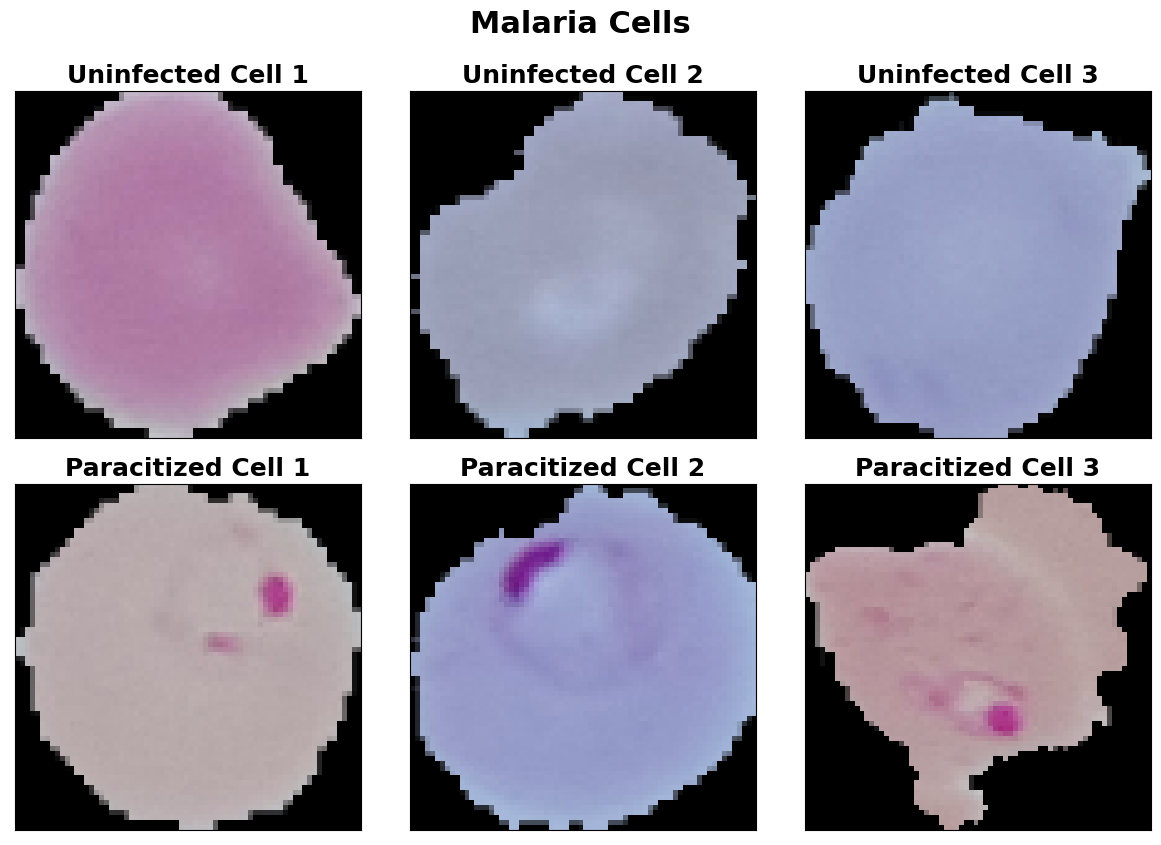

In [ ]:
# Plot Malaria Cells
def PlotCells(images, labels):
    # Randomly select 3 indices of uninfected(0) and paracitized(1)
    np.random.seed(100)
    labels = np.array(labels)
    uninfected_inds = np.random.choice(np.where(labels == 0)[0], size=3) # 3 ran
    paracitized_inds = np.random.choice(np.where(labels == 1)[0], size=3) # 3 ran
    # Subplots
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12,8), dpi=100)
    font = {'fontweight':'bold'}
    plt.suptitle('Malaria Cells', fontsize=22, **font, y=1.05)
    # Uninfected
    ax1.imshow(images[uninfected_inds[0]])
    ax2.imshow(images[uninfected_inds[1]])
    ax3.imshow(images[uninfected_inds[2]])
    ax1.set_title('Uninfected Cell 1', fontsize=18, **font)
    ax2.set_title('Uninfected Cell 2', fontsize=18, **font)
    ax3.set_title('Uninfected Cell 3', fontsize=18, **font)
    # Paracitized
    ax4.imshow(images[paracitized_inds[0]])
    ax5.imshow(images[paracitized_inds[1]])
    ax6.imshow(images[paracitized_inds[2]])
    ax4.set_title('Paracitized Cell 1', fontsize=18, **font)
    ax5.set_title('Paracitized Cell 2', fontsize=18, **font)
    ax6.set_title('Paracitized Cell 3', fontsize=18, **font)
    # Remove tick params
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
      ax.set_xticks([])
      ax.set_yticks([])
    plt.tight_layout()
    plt.show()

PlotCells(images, labels)

### (1) Build Base Neural Network

In [ ]:
# Define model
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # sigmoid
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

In [ ]:
base_model = model.fit(X, y, validation_split=0.2, batch_size=128, epochs=20, shuffle=True)

Validation Accuracy: 0.6685
Validation Loss: 0.6029


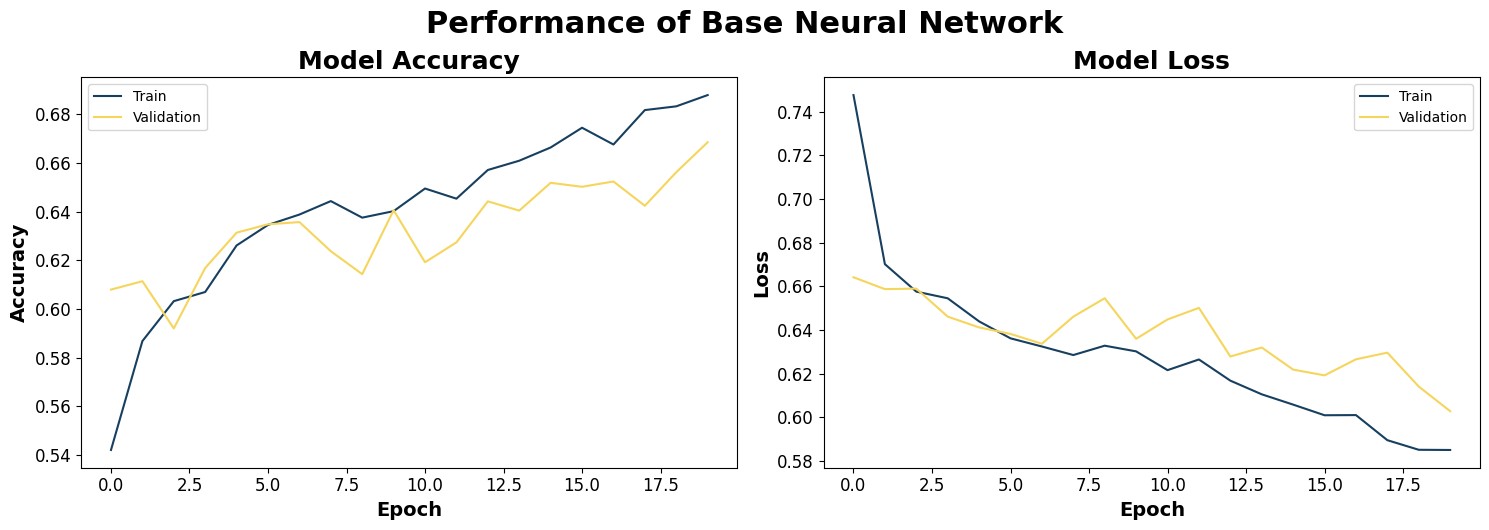

In [ ]:
PlotLossAndAccuracy(base_model, 'Performance of Base Neural Network')

### (2) Build Base Classifier (CNN)

In [ ]:
# Define model
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid') # sigmoid
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

In [ ]:
cnn = model.fit(X, y, validation_split=0.2, batch_size=128, epochs=20, shuffle=True)

Validation Accuracy: 0.8306
Validation Loss: 0.4100


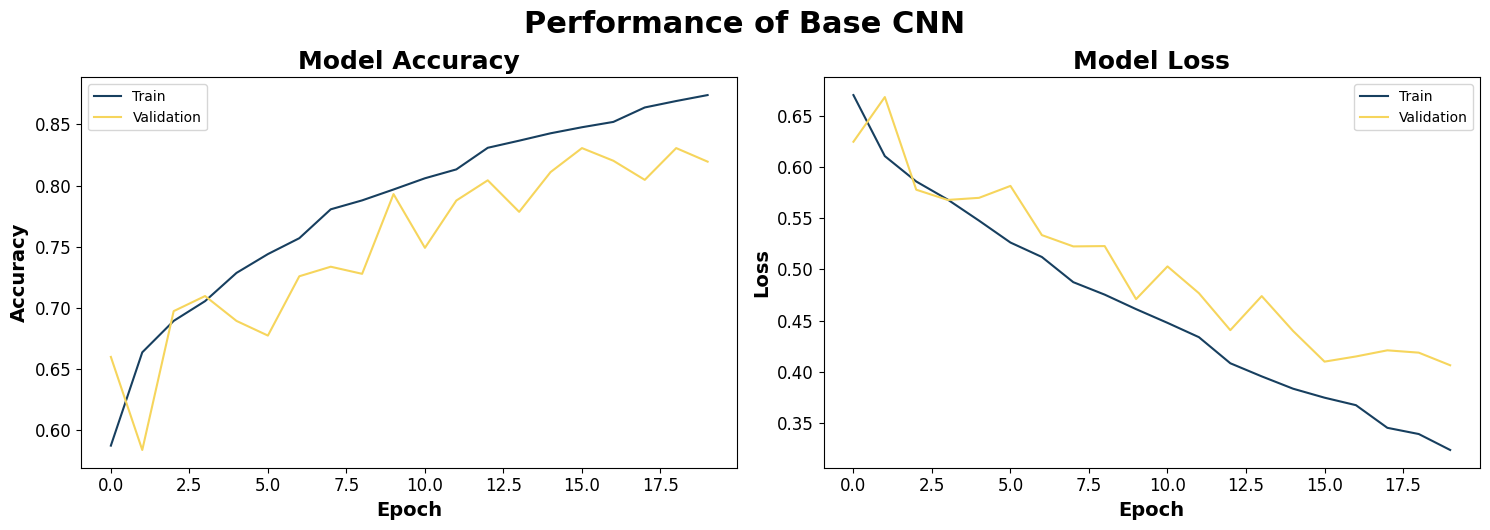

In [ ]:
PlotLossAndAccuracy(cnn, 'Performance of Base CNN')

# Data Augmentation
  - Horizontal flip
  - Rotation of factor 0.1
  - Zoom of factor 0.1


In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=INPUT_SHAPE),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

### Base Neural Network with Augmented Data

In [ ]:
model = keras.Sequential([
    data_augmentation,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # sigmoid
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

In [ ]:
base_model_augmented = model.fit(X, y, validation_split=0.2, batch_size=128, epochs=20, shuffle=True)

Validation Accuracy: 0.6716
Validation Loss: 0.6252


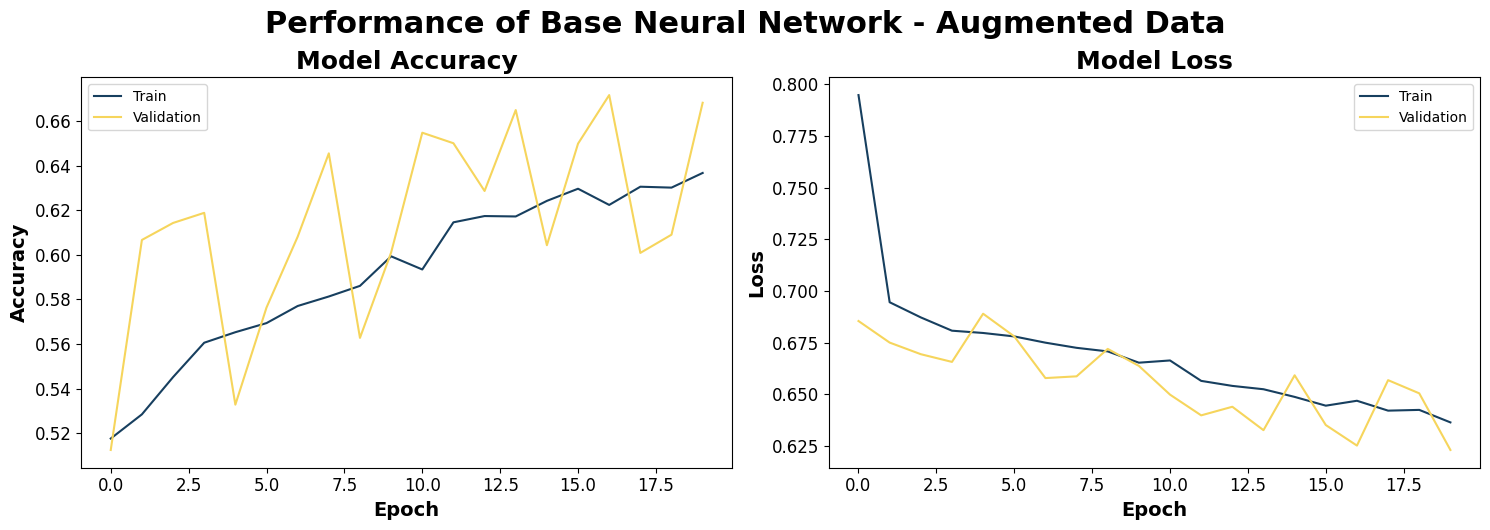

In [ ]:
PlotLossAndAccuracy(base_model_augmented, 'Performance of Base Neural Network - Augmented Data')

### CNN with Augmented Data

In [ ]:
# Define model
model = keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=INPUT_SHAPE),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid') # sigmoid
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)

In [ ]:
cnn_augmented = model.fit(X, y, validation_split=0.2, batch_size=128, epochs=20, shuffle=True)

Validation Accuracy: 0.8260
Validation Loss: 0.4278


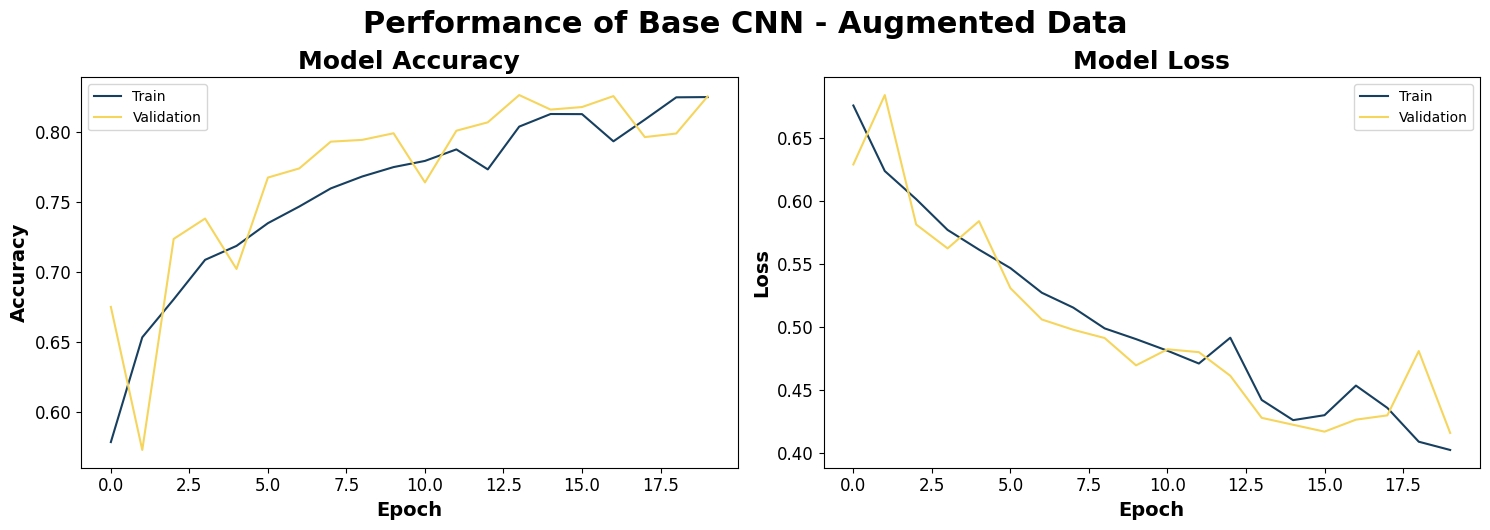

In [ ]:
PlotLossAndAccuracy(cnn_augmented, 'Performance of Base CNN - Augmented Data')

# Programmatically Find Best Neural Network Architecture (Keras Tuner)
  - Hyperparameter Tune
  - Build off of best model (Original CNN)
    - Tune without augmented data
    - Tune with augmented data

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=INPUT_SHAPE)) # pass in input shape

    # Convolution Layers (0-3) for 16, 32, 64, 128, 512, 1024 nodes
    for i in range(hp.Int('Conv Layers', min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f'conv_{i}_filters', [16,32,64,128,256,512,1024]), 3, activation='relu'))
        model.add(keras.layers.MaxPooling2D(2,2))

    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    # Dense Layers (0-3) for 16, 32, 64, 128, 256, 512, 1024 nodes
    for i in range(hp.Int('Dense Layers', min_value=0, max_value=3)):
        model.add(keras.layers.Dense(hp.Choice(f'dense_{i}_filters', [16,32,64,128,256,512,1024]), activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid')) # sigmoid

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
    directory='temp1'
)

In [ ]:
tuner.search(X, y, validation_split=0.2, batch_size=32, epochs=20, shuffle=True)

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.summary()

### Best Model Architecture
  - Validation Accuracy: 0.9562771916389465
  - LAYERS:
    - Sequential([])
    - Input(input_shape=INPUT_SHAPE)
    - Conv2D(16, 3, activation='relu')
    - MaxPooling2D(2,2)
    - Conv2D(32, 3, activation='relu')
    - MaxPooling2D(2,2)
    - Conv2D(1024, 3, activation='relu')
    - MaxPooling2D(2,2)
    - Dropout(0.5)
    - Flatten()
    - Dense(16, activation='relu')
    - Dense(1, activation='sigmoid')


In [ ]:
def build_model_augmented(hp):
    model = keras.Sequential(data_augmentation)

    # Convolution Layers (0-3) for 16, 32, 64 nodes
    for i in range(hp.Int('Conv Layers', min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f'layer_{i}_filters', [16,32,64]), 3, activation='relu'))
        model.add(keras.layers.MaxPooling2D(2,2))

    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    # Dense Layers (0-3) for 64, 128, 256, 512, 1024 nodes
    for i in range(hp.Int('Dense Layers', min_value=0, max_value=3)):
        model.add(keras.layers.Dense(hp.Choice(f'layer_{i}_filters', [64,128,256,512,1024]), activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid')) # sigmoid

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
    directory='temp'
)

In [ ]:
tuner.search(X, y, validation_split=0.2, batch_size=32, epochs=20, shuffle=True)

Trial 32 Complete [00h 00m 22s]
val_accuracy: 0.6099419593811035

Best val_accuracy So Far: 0.9392235279083252
Total elapsed time: 00h 22m 51s


In [ ]:
best_model_augmented = tuner.get_best_models()[0]

In [ ]:
best_model_augmented.summary()

### Best Model Architecture (with data augmentation):
  - Validation Accuracy: 0.9392235279083252
  - LAYERS:
    - Sequential([data_augmentation])
    - AveragePooling2D()
    - Conv2D(32, 3, activation='relu')
    - MaxPooling2D(2,2)
    - Conv2D(64, 3, activation='relu')
    - MaxPooling2D(2,2)
    - Conv2D(16, 3, activation='relu')
    - MaxPooling2D(2,2)
    - Dropout(0.5)
    - Flatten()
    - Dense(32, activation='relu')
    - Dense(64, activation='relu')
    - Dense(1, activation='sigmoid')


In [ ]:
# Without Augmented:
# Best val accuracy: 0.9562771916389465
 
# Augmented:
# Best val accuracy: 0.9392235279083252

In [ ]:
results = best_model.fit(X, y, validation_split=0.2, batch_size=32, epochs=20, shuffle=True)

Validation Accuracy: 0.9561
Validation Loss: 0.1247


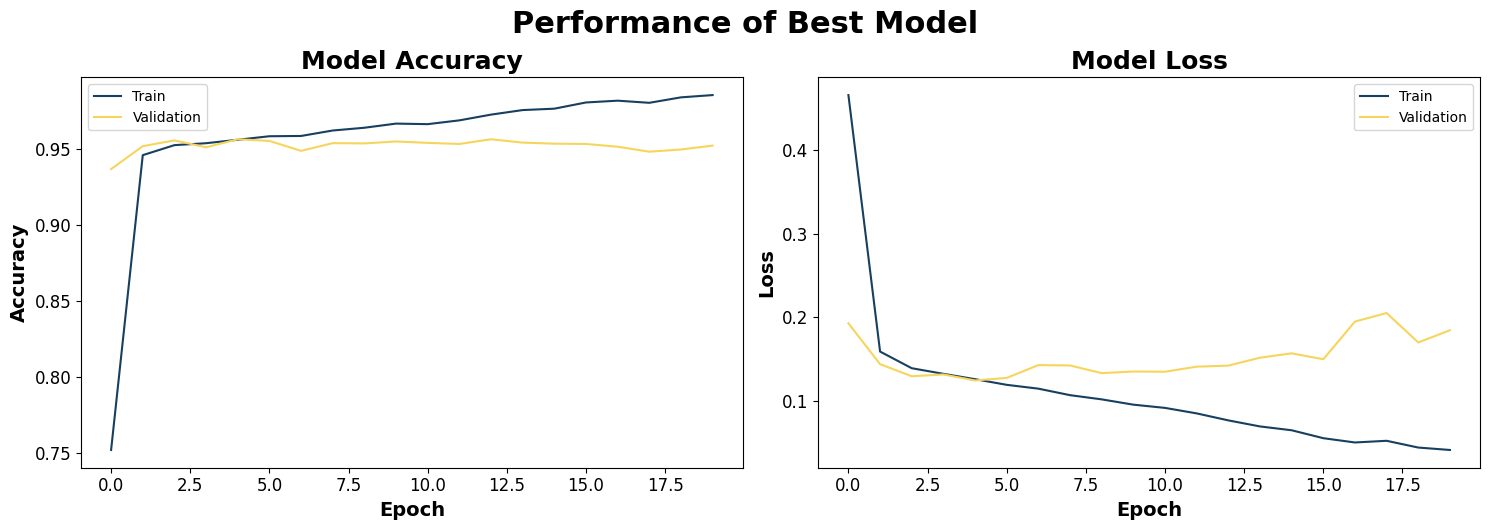

In [ ]:
PlotLossAndAccuracy(results, 'Performance of Best Model') # without data augmentation

# Precision & Recall
- Accuracy is great to use because perfect 50/50 of samples between classes
  - ie: precision and recall / AUC aren't necessarily better here, despite being a classification project
- Can check for precision and recall, however

In [ ]:
def recall_func(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_func(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_func(y_true, y_pred):
    precision = precision_func(y_true, y_pred)
    recall = recall_func(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Best model and get metrics
best_model = keras.Sequential()                                 # Sequential
best_model.add(keras.Input(shape=INPUT_SHAPE))                  # Input Layer
best_model.add(keras.layers.Conv2D(16, 3, activation='relu'))   # Convolution Layer 2
best_model.add(keras.layers.MaxPooling2D(2,2))                  # MaxPooling Layer 1
best_model.add(keras.layers.Conv2D(32, 3, activation='relu'))   # Convolution Layer 2
best_model.add(keras.layers.MaxPooling2D(2,2))                  # MaxPooling Layer 2
best_model.add(keras.layers.Conv2D(1024, 3, activation='relu')) # Convolution Layer 3
best_model.add(keras.layers.MaxPooling2D(2,2))                  # MaxPooling Layer 3
best_model.add(keras.layers.Dropout(0.5))                       # Dropout
best_model.add(keras.layers.Flatten())                          # Flatten
best_model.add(keras.layers.Dense(16, activation='relu'))       # Dense
best_model.add(keras.layers.Dense(1, activation='sigmoid'))     # Output Layer

best_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy', precision_func, recall_func , f1_func])

In [ ]:
# Get training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
history = best_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=10, shuffle=True)

# Evaluate and get metrics
loss, accuracy, precision, recall, f1_score = best_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print('Loss: %.4f' % loss)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 Score: %.4f' % f1_score)

Loss: 0.1433
Accuracy: 0.9543
Precision: 0.9706
Recall: 0.9370
F1 Score: 0.9515


In [ ]:
# Plot Precision, Recall, F1 across Epoch Values, and Precision VS Recall
def PlotAllFindings(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,8), dpi=100)
    colors = ['#173F5F', '#F6D55C']
    font = {'fontweight':'bold'}
    plt.suptitle(title, fontsize=22, **font, y=1.05)

    # Precision
    ax1.plot(history.history['precision_func'], color=colors[0])
    ax1.plot(history.history['val_precision_func'], color=colors[1])
    ax1.set_title('Model Precision', fontsize=18, **font)
    ax1.set_ylabel('Precision', fontsize=14, **font)
    ax1.legend(['Train', 'Validation'], loc='bottom left')

    # Recall
    ax2.plot(history.history['recall_func'], color=colors[0])
    ax2.plot(history.history['val_recall_func'], color=colors[1])
    ax2.set_title('Model Recall', fontsize=18, **font)
    ax2.set_ylabel('Recall', fontsize=14, **font)
    ax2.legend(['Train', 'Validation'], loc='bottom right')

    # F1 Score
    ax3.plot(history.history['f1_func'], color=colors[0])
    ax3.plot(history.history['val_f1_func'], color=colors[1])
    ax3.set_title('Model F1 Score', fontsize=18, **font)
    ax3.set_ylabel('F1 Score', fontsize=14, **font)
    ax3.legend(['Train', 'Validation'], loc='bottom right')

    # Precision VS Recall
    ax4.plot(history.history['recall_func'], history.history['precision_func'], color=colors[0])
    ax4.plot(history.history['val_recall_func'], history.history['val_precision_func'], color=colors[1])
    ax4.set_title('Model Precision VS Recall', fontsize=18, **font)
    ax4.set_xlabel('Recall', fontsize=14, **font)
    ax4.set_ylabel('Precision', fontsize=14, **font)
    ax4.tick_params(axis='both', which='major', labelsize=12)
    ax4.legend(['Train', 'Validation'], loc='bottom right')

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('Epoch', fontsize=14, **font)
        ax.tick_params(axis='both', which='major', labelsize=12)

    # Print Val Accuracy, Val Loss, Val Precision, Val Recall, Val F1 Score
    temp = history.history['val_accuracy']
    print('Validation Accuracy: %.4f' % max(temp))
    print('Validation Loss: %.4f' % history.history['val_loss'][temp.index(max(temp))])
    print('Validation Precision: %.4f' % history.history['val_precision_func'][temp.index(max(temp))])
    print('Validation Recall: %.4f' % history.history['val_recall_func'][temp.index(max(temp))])
    print('Validation F1 Score: %.4f' % history.history['val_f1_func'][temp.index(max(temp))])

    plt.tight_layout()
    plt.show()

Validation Accuracy: 0.9542
Validation Loss: 0.1430
Validation Precision: 0.9711
Validation Recall: 0.9382
Validation F1 Score: 0.9529


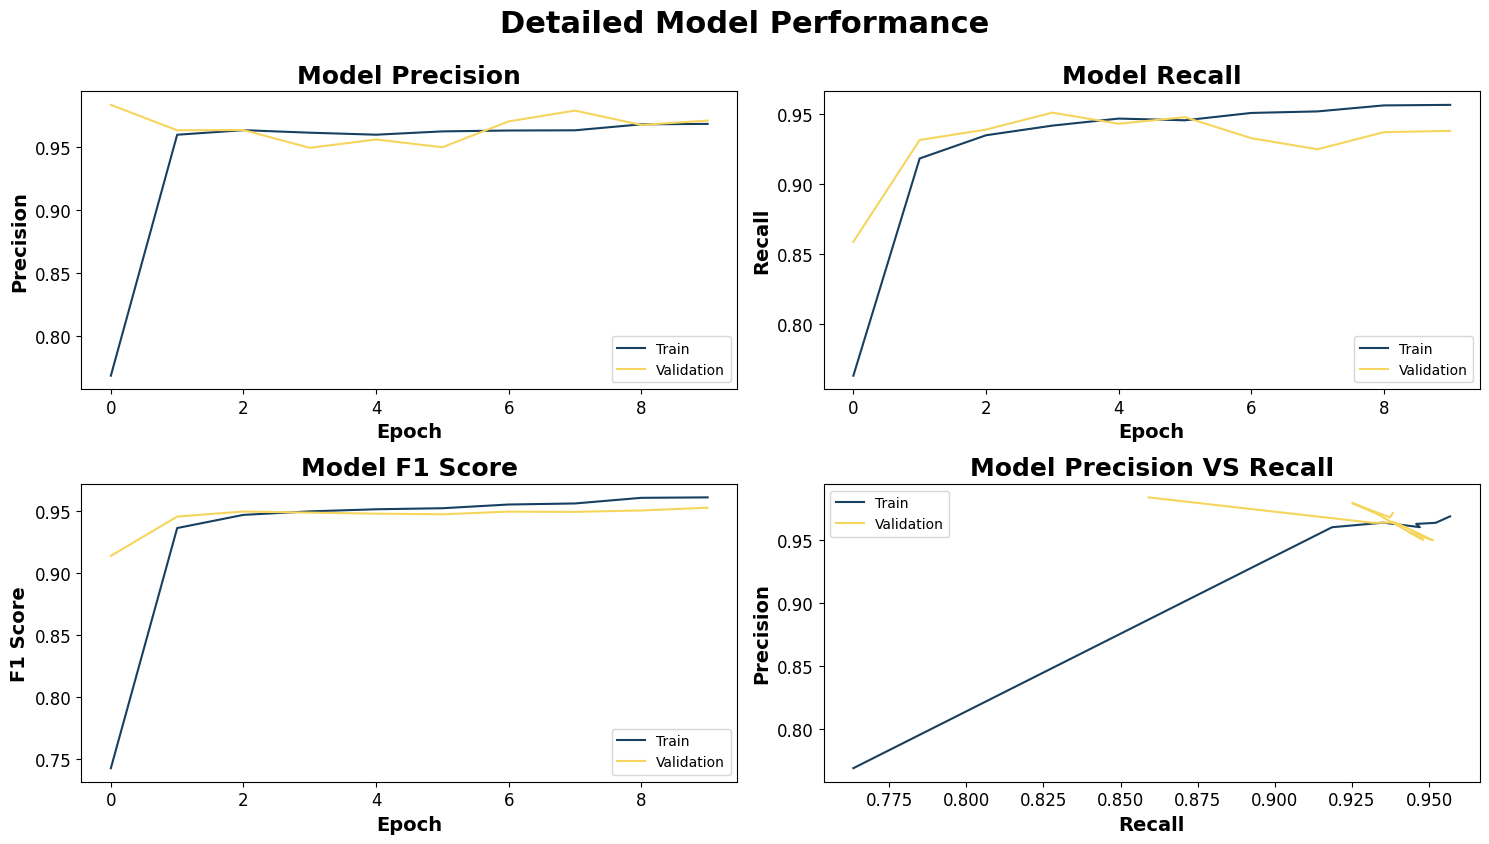

In [ ]:
PlotAllFindings(history, 'Detailed Model Performance')

# Save / Load Model

In [ ]:
# Best Model
best_model = keras.Sequential()                                 # Sequential
best_model.add(keras.Input(shape=INPUT_SHAPE))                  # Input Layer
best_model.add(keras.layers.Conv2D(16, 3, activation='relu'))   # Convolution Layer 2
best_model.add(keras.layers.MaxPooling2D(2,2))                  # MaxPooling Layer 1
best_model.add(keras.layers.Conv2D(32, 3, activation='relu'))   # Convolution Layer 2
best_model.add(keras.layers.MaxPooling2D(2,2))                  # MaxPooling Layer 2
best_model.add(keras.layers.Conv2D(1024, 3, activation='relu')) # Convolution Layer 3
best_model.add(keras.layers.MaxPooling2D(2,2))                  # MaxPooling Layer 3
best_model.add(keras.layers.Dropout(0.5))                       # Dropout
best_model.add(keras.layers.Flatten())                          # Flatten
best_model.add(keras.layers.Dense(16, activation='relu'))       # Dense
best_model.add(keras.layers.Dense(1, activation='sigmoid'))     # Output Layer

best_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# Save model
best_model.save('./best_model')

In [ ]:
# Load model
loaded_model = keras.models.load_model('./best_model')